## Visualization of results

In [204]:
# autoreload
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt

from data_processing import *
from model import AllenCahnFNO
from training import *

# TODO
# model doesn't respect boundary conditions, address in report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
data_in = load_npz_data("data/test_data_standard.npz", for_exploration=True)
data_out = load_npz_data("data/test_data_OOD.npz", for_exploration=True)
# train_data = load_npz_data("data/training_data_standard.npz")

model = AllenCahnFNO()
model.load_state_dict(torch.load("models/best_model_AllenCahnFNO_lr0.001_bs32_epochs150_valloss0.000117.pt", map_location=torch.device('cpu')))
# model.load_state_dict(torch.load("models/best_model_AllenCahnFNO_lr0.001_bs32_epochs100_valloss0.000101.pt", map_location=torch.device('cpu')))
model.eval()
print("model loaded")

model loaded


C:\Users\paesc\AppData\Local\Temp\ipykernel_3972\2910655824.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/best_model_AllenCahn

Boundary conditions for eps=0.02:
Prediction at x=0: 0.3308906853199005
Prediction at x=1: 0.3174383342266083
Boundary conditions for eps=0.05:
Prediction at x=0: -0.7856398820877075
Prediction at x=1: -0.7829726338386536
Boundary conditions for eps=0.1:
Prediction at x=0: -0.45308107137680054
Prediction at x=1: -0.4523204267024994
Boundary conditions for eps=0.01:
Prediction at x=0: 1.0379714965820312
Prediction at x=1: 1.0462034940719604
Boundary conditions for eps=0.03:
Prediction at x=0: 0.9384253621101379
Prediction at x=1: 0.8969206213951111
Boundary conditions for eps=0.15:
Prediction at x=0: 0.10206770151853561
Prediction at x=1: 0.15417809784412384


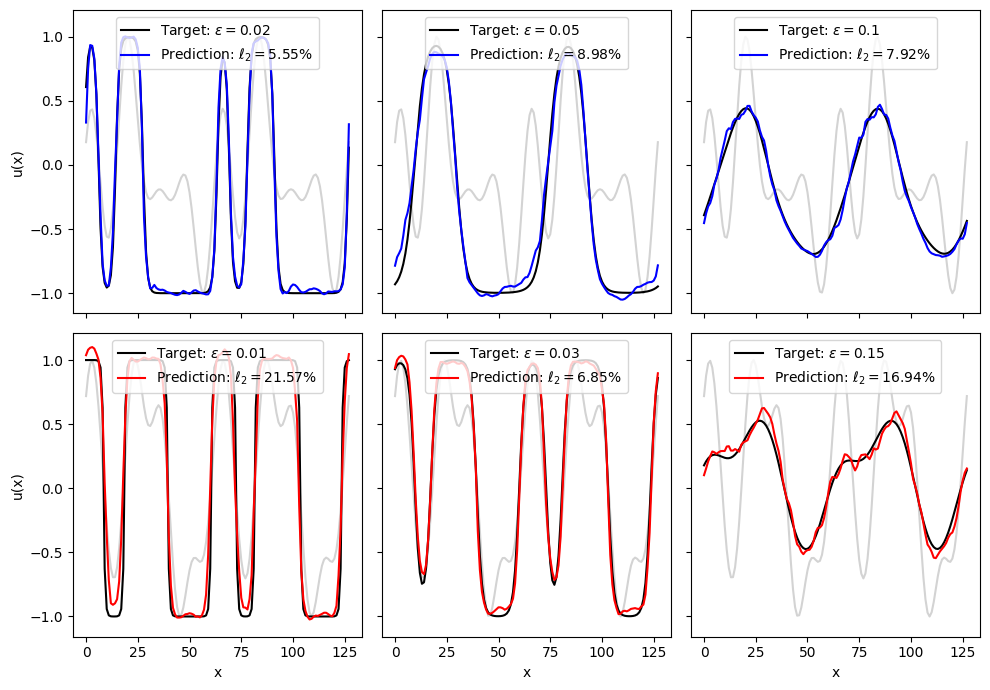

In [207]:
# Parameters
ic = "fourier"
in_distr_eps = [0.02, 0.05, 0.1]
ood_eps = [0.01, 0.03, 0.15]
time_steps = 4
time_scale = 0.0025
sample_id = 0
device = torch.device("cpu")

# Create 2x3 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

# Helper function to plot data
def plot_trajectory(ax, data, model, eps, time_steps, sample_id, time_scale, label_prefix, color):
    inputs = data[ic][eps][sample_id, 0, :]
    inputs_t = torch.ones(inputs.size(0)) * time_steps * time_scale  # Time channel
    inputs_g = torch.linspace(-1, 1, inputs.size(0))  # Grid channel
    inputs_eps = torch.ones(inputs.size(0)) * eps  # Epsilon channel
    inputs = torch.stack((inputs, inputs_g, inputs_t, inputs_eps), -1).unsqueeze(0)
    target = data[ic][eps][sample_id, time_steps, :].unsqueeze(0).unsqueeze(-1)
    eps_input = torch.FloatTensor([eps]).unsqueeze(0)
    time_input = torch.FloatTensor([time_steps * time_scale]).unsqueeze(0)
    
    preds = model(inputs.to(device), eps_input.to(device), time_input.to(device))
    rel_L2 = avg_rel_L2_error(preds, target)
    
    # Plot
    ax.plot(inputs[0, :, 0].detach().numpy(), color = "lightgray")#, label=f"IC: u(t=0)", color="lightgray")
    ax.plot(target[0, :, :].detach().numpy(), label=f"Target: $\epsilon = {eps}$", color="black") # u(t={time_steps * time_scale})
    ax.plot(preds[0, :, :].detach().numpy(), label=f"Prediction: $\ell_2 = {round(rel_L2, 4) * 100:.2f}$%", color=color)
    ax.legend(loc = "upper center")
    # ax.set_title(f"{label_prefix}, Epsilon = {eps}")
    # ax.set_xlabel("Grid Points")
    # ax.set_ylabel("u(x)")
    # check if boundary conditions are respected in predictions
    print(f"Boundary conditions for eps={eps}:")
    print(f"Prediction at x=0: {preds[0, 0, 0]}")
    print(f"Prediction at x=1: {preds[0, -1, 0]}")

# Plot In-Distribution (upper row)
for i, eps in enumerate(in_distr_eps):
    plot_trajectory(axs[0, i], data_in, model, eps, time_steps, sample_id, time_scale, "In-Distr", "blue")

# Plot Out-of-Distribution (lower row)
for i, eps in enumerate(ood_eps):
    plot_trajectory(axs[1, i], data_out, model, eps, time_steps, sample_id, time_scale, "Out-of-Distr", "red")

for i in range(3):
    axs[1, i].set_xlabel("x")
for j in range(2):
    axs[j, 0].set_ylabel("u(x)")
# Adjust layout and show
plt.tight_layout()
plt.show()


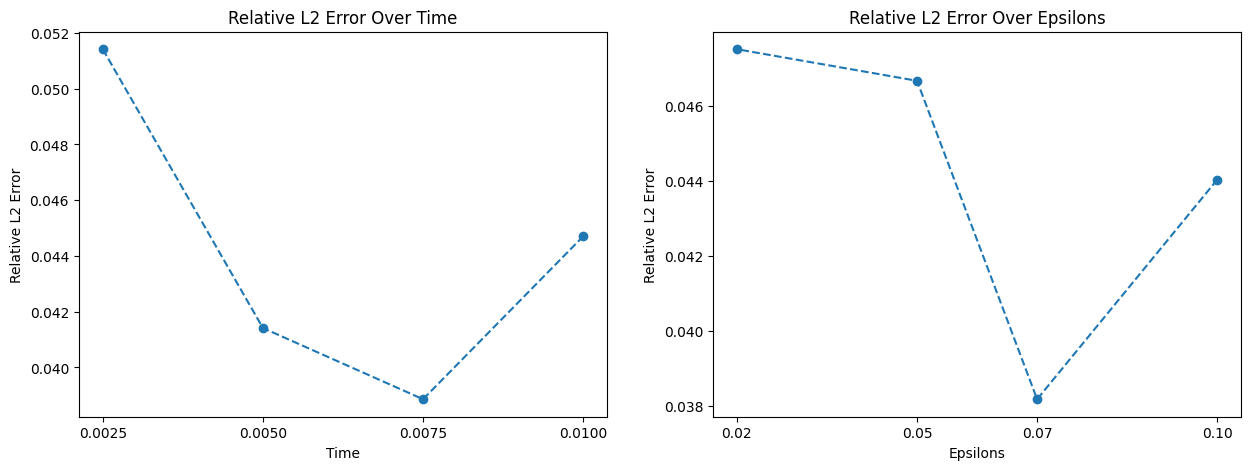

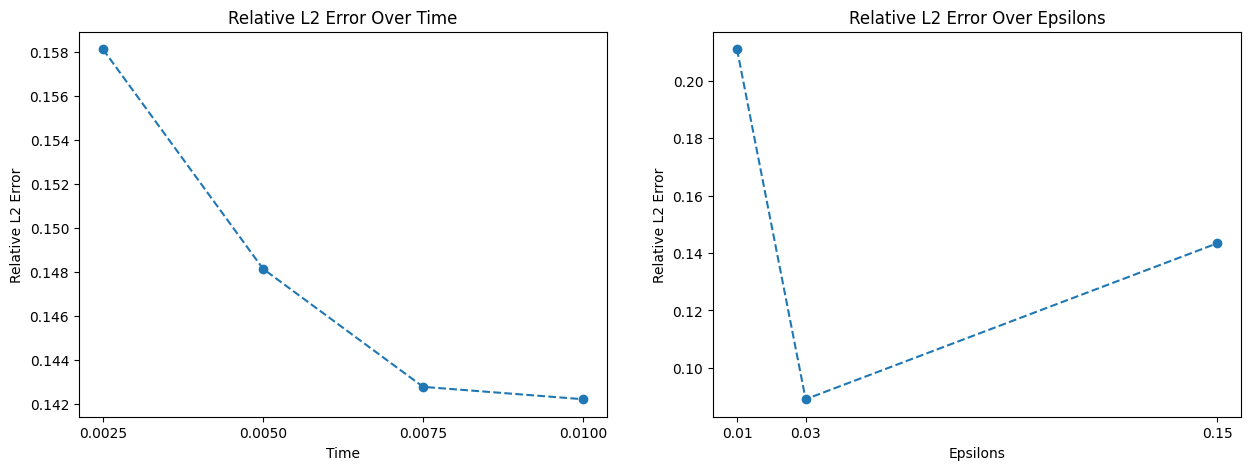

InD, time: {0.0025: 0.05141369625926018, 0.005: 0.041414495557546616, 0.0075: 0.038861025124788284, 0.01: 0.04470202699303627}
InD, eps: {0.1: 0.04403330758213997, 0.07: 0.03818213939666748, 0.05: 0.04666721820831299, 0.02: 0.04750857874751091}
OOD, time: {0.0025: 0.15811076760292053, 0.005: 0.1481322944164276, 0.0075: 0.14276954531669617, 0.01: 0.14220774173736572}
OOD, eps: {0.01: 0.21096739172935486, 0.03: 0.08906235545873642, 0.15: 0.14338548481464386}


In [199]:
test_data = load_npz_data("data/test_data_standard.npz", for_exploration=False)
OOD_test_data = load_npz_data("data/test_data_OOD.npz", for_exploration=False)
epsilon_values_in = list(test_data.keys())
epsilon_values_out = list(OOD_test_data.keys())
time_points = [0, 0.0025, 0.005, 0.0075, 0.01]
# print(test_data.keys())
# test_relative_l2_time, test_relative_l2_epsilon = test_model(trained_model, test_data, epsilon_values, time_points, show_plot=True)

test_relative_l2_time, test_relative_l2_epsilon = test_model(model, test_data, epsilon_values_in, time_points, show_plot=True)
OOD_test_relative_l2_time, OOD_test_relative_l2_epsilon = test_model(model, OOD_test_data, [0.01, 0.03, 0.15], time_points, show_plot=True)

print("InD, time:", test_relative_l2_time)
print("InD, eps:", test_relative_l2_epsilon)
print("OOD, time:", OOD_test_relative_l2_time)
print("OOD, eps:", OOD_test_relative_l2_epsilon)

C:\Users\paesc\AppData\Local\Temp\ipykernel_3972\1172650296.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(["5%", "10%", "15%", "20%", "25%", "30%"])


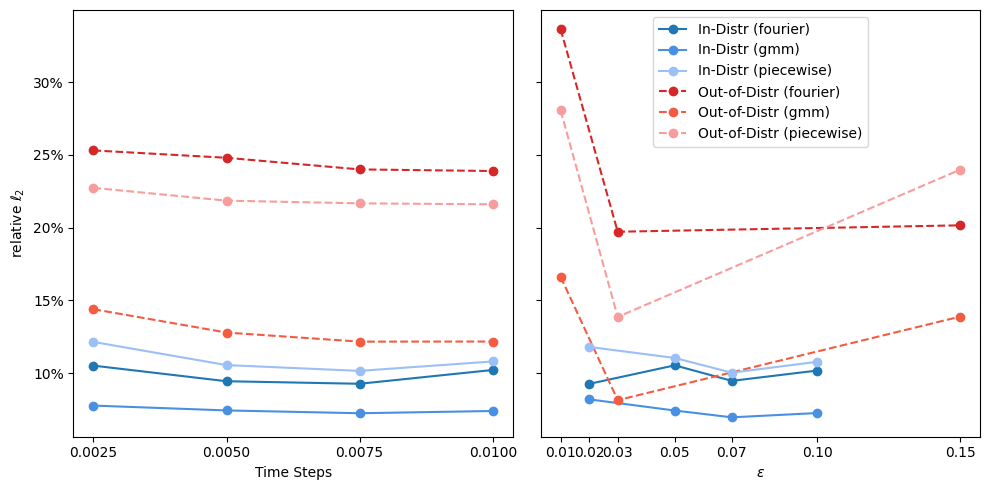

In [200]:
# Data keys
keys = ["fourier", "gmm", "piecewise"]

test_data = load_npz_data("data/test_data_standard.npz", for_exploration=True)
OOD_test_data = load_npz_data("data/test_data_OOD.npz", for_exploration=True)

# Colors for the plots
colors_in_distr = ["#1f77b4", "#4a90e2", "#9bbff7"]  # Blue-toned for in-distribution
colors_out_distr = ["#d62728", "#f45c42", "#f99c9c"]  # Red-toned for out-of-distribution

# Prepare subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Storage for legend handles and labels
handles_in_distr = []
handles_out_distr = []

# Loop over keys to plot lines
for i, key in enumerate(keys):
    # Compute relative L2 errors
    test_relative_l2_time, test_relative_l2_epsilon = test_model(model, test_data[key], epsilon_values_in, time_points, show_plot=False)
    OOD_test_relative_l2_time, OOD_test_relative_l2_epsilon = test_model(model, OOD_test_data[key], [0.01, 0.03, 0.15], time_points, show_plot=False)
    
    # Plot In-Distribution
    line_in_time, = axs[0].plot(test_relative_l2_time.keys(), test_relative_l2_time.values(), color=colors_in_distr[i], marker = "o", label=f"In-Distr ({key})")
    line_in_eps, = axs[1].plot(test_relative_l2_epsilon.keys(), test_relative_l2_epsilon.values(), color=colors_in_distr[i], marker = "o", label=f"In-Distr ({key})")
    handles_in_distr.append(line_in_time)  # Collect legend handles
    
    # Plot Out-of-Distribution
    line_out_time, = axs[0].plot(OOD_test_relative_l2_time.keys(), OOD_test_relative_l2_time.values(), color=colors_out_distr[i], marker = "o", linestyle="--", label=f"Out-of-Distr ({key})")
    line_out_eps, = axs[1].plot(OOD_test_relative_l2_epsilon.keys(), OOD_test_relative_l2_epsilon.values(), color=colors_out_distr[i], marker = "o", linestyle="--", label=f"Out-of-Distr ({key})")
    handles_out_distr.append(line_out_time)  # Collect legend handles

# Combine handles for a sorted legend
all_handles = handles_in_distr + handles_out_distr
all_labels = [f"In-Distr ({key})" for key in keys] + [f"Out-of-Distr ({key})" for key in keys]

# Customize the first subplot
# axs[0].set_title("Relative L2 Error over Time")
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("relative $\ell_2$")
# axs[0].set_yscale('log')  # Log scale for better visualization
axs[0].set_yticklabels(["5%", "10%", "15%", "20%", "25%", "30%"])
axs[0].set_xticks(time_points[1:])
# axs[0].legend(all_handles, all_labels)  # Sorted legend

# Customize the second subplot
# axs[1].set_title("Relative L2 Error over Epsilon")
axs[1].set_xlabel("$\epsilon$")
# axs[1].set_ylabel("Relative L2 Error")
# axs[1].set_yscale('log')  # Log scale for better visualization
axs[1].set_xticks(epsilon_values_in + [0.01, 0.03, 0.15])
axs[1].legend(all_handles, all_labels, loc = "upper center")  # Sorted legend

# Adjust layout and display
plt.tight_layout()
plt.show()
